<a href="https://colab.research.google.com/github/parseny/Generative-Models-2024/blob/main/Assignment%203/3_ddpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models
***

**Autumn 2024**

## Assignment 3


In this assignment we implement DDPM - Denoising Diffusion Probabilistic Models (2020)

In simple terms, we get an image from data and add noise step by step. Then We train a model to predict that noise at each step and use the model to generate images.

The following definitions and derivations show how this works. For details please refer to the paper https://arxiv.org/abs/2006.11239

## Forward Process

The forward process adds noise to the data $x_0 \sim q(x_0)$, for $T$ timesteps.

\begin{align}
q(x_t | x_{t-1}) = \mathcal{N}\big(x_t; \sqrt{1-  \beta_t} x_{t-1}, \beta_t \mathbf{I}\big) \\
q(x_{1:T} | x_0) = \prod_{t = 1}^{T} q(x_t | x_{t-1})
\end{align}

where $\beta_1, \dots, \beta_T$ is the variance schedule.

We can sample $x_t$ at any timestep $t$ with,

\begin{align}
q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
\end{align}

where $\alpha_t = 1 - \beta_t$ and $\bar\alpha_t = \prod_{s=1}^t \alpha_s$

## Reverse Process

The reverse process removes noise starting at $p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$
for $T$ time steps.

\begin{align}
p_\theta(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
 \mu_\theta(x_t, t), \Sigma_\theta(x_t, t)\big) \\
p_\theta(x_{0:T}) &= p_\theta(x_T) \prod_{t = 1}^{T} p_\theta(x_{t-1} | x_t) \\
p_\theta(x_0) &= \int p_\theta(x_{0:T}) dx_{1:T}
\end{align}

$\theta$ are the parameters we train.

## Loss

We optimize the ELBO (from Jenson's inequality) on the negative log likelihood.

\begin{align}
\mathbb{E}[-\log p_\theta(x_0)]
 &\le \mathbb{E}_q [ -\log \frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)} ] \\
 &=L
\end{align}

The loss can be rewritten as  follows.

\begin{align}
L
 &= \mathbb{E}_q [ -\log \frac{p_\theta(x_{0:T})}{q(x_{1:T}|x_0)} ] \\
 &= \mathbb{E}_q [ -\log p(x_T) - \sum_{t=1}^T \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_t|x_{t-1})} ] \\
 &= \mathbb{E}_q [
  -\log \frac{p(x_T)}{q(x_T|x_0)}
  -\sum_{t=2}^T \log \frac{p_\theta(x_{t-1}|x_t)}{q(x_{t-1}|x_t,x_0)}
  -\log p_\theta(x_0|x_1)] \\
 &= \mathbb{E}_q [
   D_{KL}(q(x_T|x_0) \Vert p(x_T))
  +\sum_{t=2}^T D_{KL}(q(x_{t-1}|x_t,x_0) \Vert p_\theta(x_{t-1}|x_t))
  -\log p_\theta(x_0|x_1)]
\end{align}

$D_{KL}(q(x_T|x_0) \Vert p(x_T))$ is constant since we keep $\beta_1, \dots, \beta_T$ constant.

### Computing $L_{t-1} = D_{KL}(q(x_{t-1}|x_t,x_0) \Vert p_\theta(x_{t-1}|x_t))$

The forward process posterior conditioned by $x_0$ is,

\begin{align}
q(x_{t-1}|x_t, x_0) &= \mathcal{N} \Big(x_{t-1}; \tilde\mu_t(x_t, x_0), \tilde\beta_t \mathbf{I} \Big) \\
\tilde\mu_t(x_t, x_0) &= \frac{\sqrt{\bar\alpha_{t-1}}\beta_t}{1 - \bar\alpha_t}x_0
                         + \frac{\sqrt{\alpha_t}(1 - \bar\alpha_{t-1})}{1-\bar\alpha_t}x_t \\
\tilde\beta_t &= \frac{1 - \bar\alpha_{t-1}}{1 - \bar\alpha_t} \beta_t
\end{align}

The paper sets $\Sigma_\theta(x_t, t) = \sigma_t^2 \mathbf{I}$ where $\sigma_t^2$ is set to constants
$\beta_t$ or $\tilde\beta_t$.

Then,
$$p_\theta(x_{t-1} | x_t) = \mathcal{N}\big(x_{t-1}; \mu_\theta(x_t, t), \sigma_t^2 \mathbf{I} \big)$$

For given noise $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$ using $q(x_t|x_0)$

\begin{align}
x_t(x_0, \epsilon) &= \sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon \\
x_0 &= \frac{1}{\sqrt{\bar\alpha_t}} \Big(x_t(x_0, \epsilon) -  \sqrt{1-\bar\alpha_t}\epsilon\Big)
\end{align}

This gives,

\begin{align}
L_{t-1}
 &= D_{KL}(q(x_{t-1}|x_t,x_0) \Vert p_\theta(x_{t-1}|x_t)) \\
 &= \mathbb{E}_q \Bigg[ \frac{1}{2\sigma_t^2}
 \Big \Vert \tilde\mu(x_t, x_0) - \mu_\theta(x_t, t) \Big \Vert^2 \Bigg] \\
 &= \mathbb{E}_{x_0, \epsilon} \Bigg[ \frac{1}{2\sigma_t^2}
  \bigg\Vert \frac{1}{\sqrt{\alpha_t}} \Big(
  x_t(x_0, \epsilon) - \frac{\beta_t}{\sqrt{1 - \bar\alpha_t}} \epsilon
  \Big) - \mu_\theta(x_t(x_0, \epsilon), t) \bigg\Vert^2 \Bigg] \\
\end{align}

Re-parameterizing with a model to predict noise

\begin{align}
\mu_\theta(x_t, t) &= \tilde\mu \bigg(x_t,
  \frac{1}{\sqrt{\bar\alpha_t}} \Big(x_t -
   \sqrt{1-\bar\alpha_t}\epsilon_\theta(x_t, t) \Big) \bigg) \\
  &= \frac{1}{\sqrt{\alpha_t}} \Big(x_t -
  \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\epsilon_\theta(x_t, t) \Big)
\end{align}

where $\epsilon_\theta$ is a learned function that predicts $\epsilon$ given $(x_t, t)$.

This gives,

\begin{align}
L_{t-1}
&= \mathbb{E}_{x_0, \epsilon} \Bigg[ \frac{\beta_t^2}{2\sigma_t^2 \alpha_t (1 - \bar\alpha_t)}
  \Big\Vert
  \epsilon - \epsilon_\theta(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)
  \Big\Vert^2 \Bigg]
\end{align}

That is, we are training to predict the noise.

### Simplified loss

$$L_{\text{simple}}(\theta) = \mathbb{E}_{t,x_0, \epsilon} \Bigg[ \bigg\Vert
\epsilon - \epsilon_\theta(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)
\bigg\Vert^2 \Bigg]$$

This minimizes $-\log p_\theta(x_0|x_1)$ when $t=1$ and $L_{t-1}$ for $t\gt1$ discarding the
weighting in $L_{t-1}$. Discarding the weights $\frac{\beta_t^2}{2\sigma_t^2 \alpha_t (1 - \bar\alpha_t)}$
increase the weight given to higher $t$ (which have higher noise levels), therefore increasing the sample quality.

This file implements the loss calculation and a basic sampling method that we use to generate images during
training.

$\epsilon_\theta(x_t, t)$ is a UNet model.

In [1]:
from typing import List, Tuple, Optional

import torch
import torch.nn.functional as F
import torch.utils.data
from torch import nn
import torchvision
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# Load file unet.py to the filesystem of colab
# from unet import UNet
import math
from typing import Optional, Tuple, Union, List

import torch
from torch import nn


class Swish(nn.Module):
    """
    ### Swish actiavation function

    $$x \cdot \sigma(x)$$
    """

    def forward(self, x):
        return x * torch.sigmoid(x)


class TimeEmbedding(nn.Module):
    """
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: int):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        # Create sinusoidal position embeddings
        # [same as those from the transformer](../../transformers/positional_encoding.html)
        #
        # \begin{align}
        # PE^{(1)}_{t,i} &= sin\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg) \\
        # PE^{(2)}_{t,i} &= cos\Bigg(\frac{t}{10000^{\frac{i}{d - 1}}}\Bigg)
        # \end{align}
        #
        # where $d$ is `half_dim`
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb


class ResidualBlock(nn.Module):
    """
    ### Residual block

    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int,
                 n_groups: int = 32, dropout: float = 0.1):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step ($t$) embeddings
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        * `dropout` is the dropout rate
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)
        self.time_act = Swish()

        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.time_emb(self.time_act(t))[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.dropout(self.act2(self.norm2(h))))

        # Add the shortcut connection and return
        return h + self.shortcut(x)


class AttentionBlock(nn.Module):
    """
    ### Attention block

    This is similar to [transformer multi-head attention](../../transformers/mha.html).
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=2)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


class DownBlock(nn.Module):
    """
    ### Down block

    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):
    """
    ### Up block

    This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):
    """
    ### Middle block

    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    """
    ### Scale up the feature map by $2 \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    """
    ### Scale down the feature map by $\frac{1}{2} \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class UNet(nn.Module):
    """
    ## U-Net
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[bool]] = (False, False, True, True),
                 n_blocks: int = 2):
        """
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        """

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))


In [15]:
def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for t and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

### Explanations to the code
[1] $\bar\alpha_t = \prod_{s=1}^t \alpha_s$

[2] \begin{align}
        q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
        \end{align}

[3] gather $\alpha_t$ and compute $\sqrt{\bar\alpha_t} x_0$

[4] $(1-\bar\alpha_t) \mathbf{I}$

[5] \begin{align}
        q(x_t|x_0) &= \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)
        \end{align}

[6] $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$

[7] \begin{align}
        p_\theta(x_{t-1} | x_t) &= \mathcal{N}\big(x_{t-1};
        \mu_\theta(x_t, t), \sigma_t^2 \mathbf{I} \big) \\
        \mu_\theta(x_t, t)
          &= \frac{1}{\sqrt{\alpha_t}} \Big(x_t -
            \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\epsilon_\theta(x_t, t) \Big)
        \end{align}

[8] gather $\bar\alpha_t$

[9] $\frac{\beta}{\sqrt{1-\bar\alpha_t}}$

[10] $$\frac{1}{\sqrt{\alpha_t}} \Big(x_t -
              \frac{\beta_t}{\sqrt{1-\bar\alpha_t}}\epsilon_\theta(x_t, t) \Big)$$

[11] $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$

[12] $$L_{\text{simple}}(\theta) = \mathbb{E}_{t,x_0, \epsilon} \Bigg[ \bigg\Vert
        \epsilon - \epsilon_\theta(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)
        \bigg\Vert^2 \Bigg]$$

[13] $\epsilon \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$

[14] Get $\epsilon_\theta(\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)$

In [16]:
beta = torch.linspace(0.0001, 0.02, 10)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)  # Используем torch.cumprod для кумулятивного произведения
print("Alpha_bar (cumulative product of alpha):", alpha_bar)
t = torch.tensor([1,2,3])
print(alpha[t])
print(gather(alpha, t).squeeze())
gather(alpha_bar, torch.tensor([1,2,3]))

Alpha_bar (cumulative product of alpha): tensor([0.9999, 0.9976, 0.9931, 0.9864, 0.9776, 0.9667, 0.9537, 0.9389, 0.9222,
        0.9037])
tensor([0.9977, 0.9955, 0.9933])
tensor([0.9977, 0.9955, 0.9933])


tensor([[[[0.9976]]],


        [[[0.9931]]],


        [[[0.9864]]]])

In [17]:
class DenoiseDiffusion:
    """
    ## Denoise Diffusion
    """

    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        """
        * eps_model - epsilon_theta(x_t, t) model
        * n_steps - t
        * device - the device to place constants on
        """
        super().__init__()
        self.eps_model = eps_model

        # Create beta_1 ... beta_T linearly increasing variance schedule
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)

        # alpha_t = 1 - beta_t
        self.alpha = 1 - self.beta
        # [1]
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        # T
        self.n_steps = n_steps
        # sigma^2 = beta
        self.sigma2 = self.beta

    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Get q(x_t|x_0) distribution

        [2]
        """
        # [3]
        mean = gather(self.alpha_bar, t) ** 0.5 * x0
        # [4]
        var = 1 - gather(self.alpha_bar, t)
        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        """
        Sample from q(x_t|x_0)

        [5]
        """

        # [6]
        if eps is None:
            eps = torch.randn_like(x0)

        # get q(x_t|x_0)
        mean, var = self.q_xt_x0(x0, t)

        # Sample from q(x_t|x_0)
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        """
        Sample from p_theta(x_{t-1}|x_t)

        [7]
        """

        # epsilon_theta(x_t, t)
        eps_theta = self.eps_model(xt, t)

        # [8]
        alpha_bar = gather(self.alpha_bar, t)

        # alpha_t
        alpha_t = gather(self.alpha, t)

        # [9]
        beta = 1 - alpha_t
        eps_coef = beta / (1 - alpha_bar) ** 0.5

        # [10]
        mean = (1 / alpha_t ** 0.5) * (xt - eps_coef * eps_theta)

        # sigma^2
        var = gather(self.sigma2, t)

        # [11]
        eps = eps = torch.randn_like(xt)

        # Sample
        return mean + (var ** .5) * eps

    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None):
        """
        Simplified Loss

        [12]
        """
        # Get batch size
        batch_size = x0.size(0)

        # Get random t for each sample in the batch
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device)

        # [13]
        if noise is None:
            noise = torch.randn_like(x0)

        # Sample x_t for q(x_t|x_0)
        xt = self.q_sample(x0, t, noise)
        # print(f"xt\n{xt}")
        # [14]
        eps_theta = self.eps_model(xt, t)
        # print(f"eps_theta\n{eps_theta}")
        # MSE loss
        return torch.mean((noise - eps_theta) ** 2)

### Explanations to the code
[1] $x_T \sim p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$

[2] Sample from $p_\theta(x_{t-1}|x_t)$



Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.37it/s]


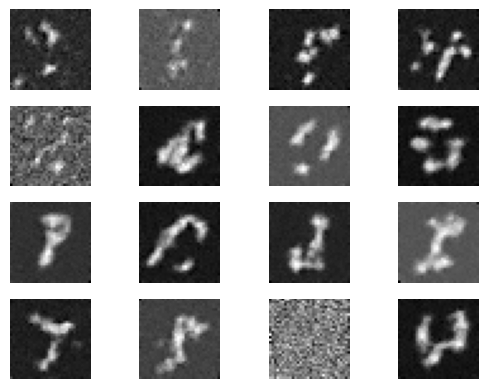

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.36it/s]


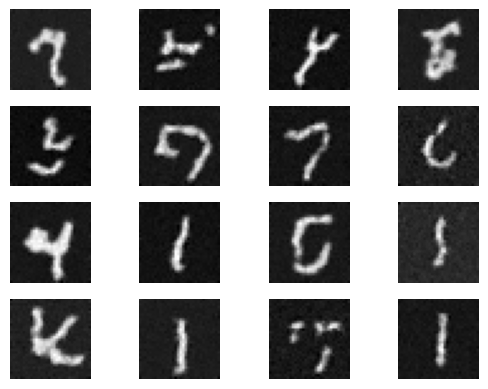

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.35it/s]


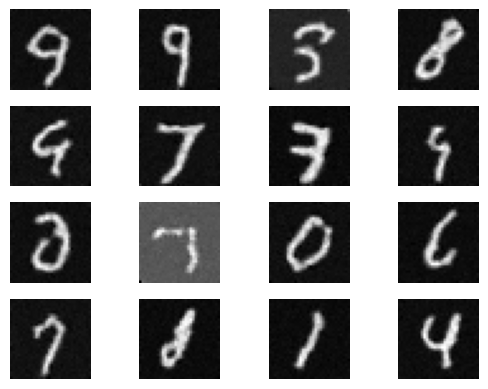

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.34it/s]


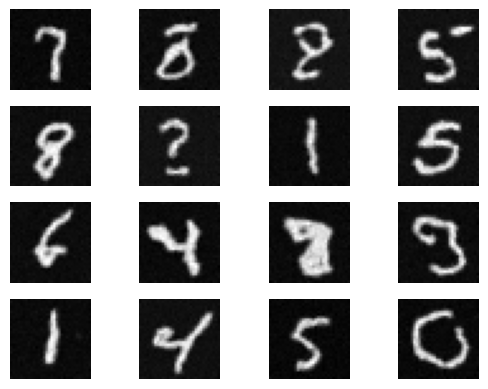

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.32it/s]


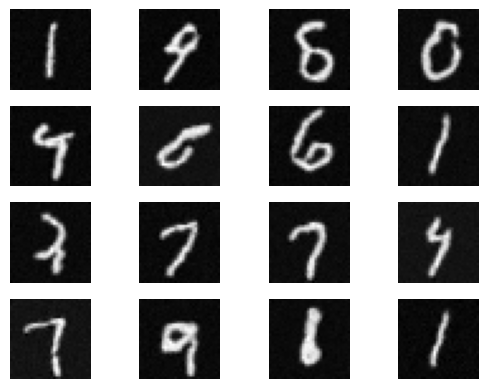

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.34it/s]


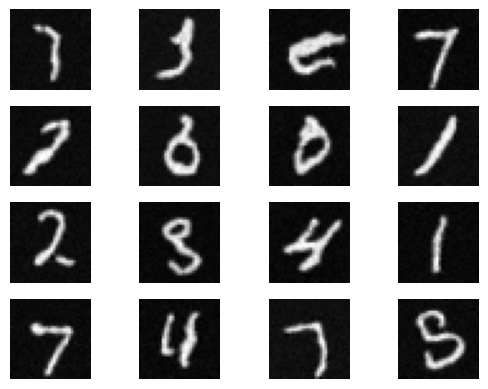

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.33it/s]


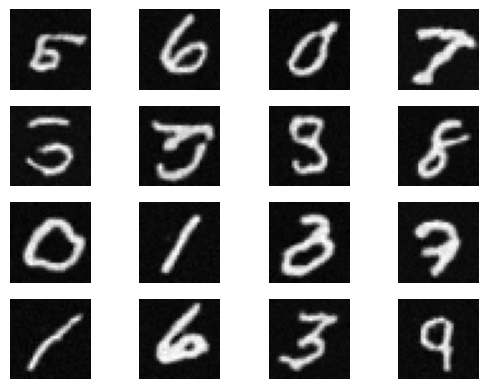

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.36it/s]


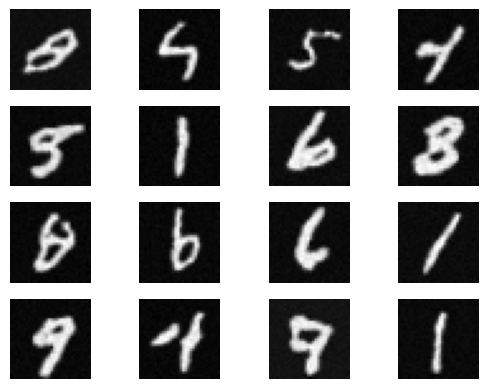

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.35it/s]


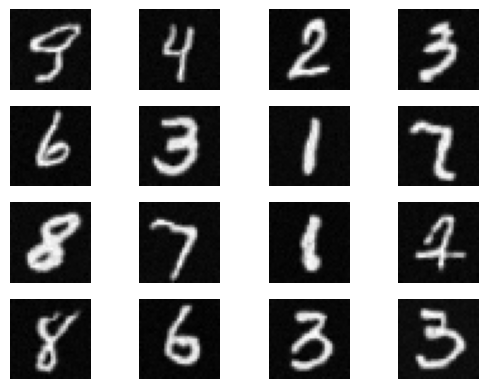

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.35it/s]


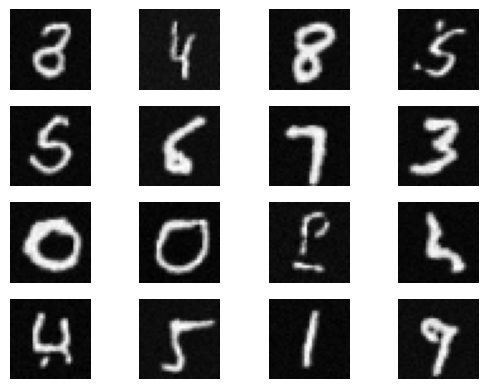

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.31it/s]


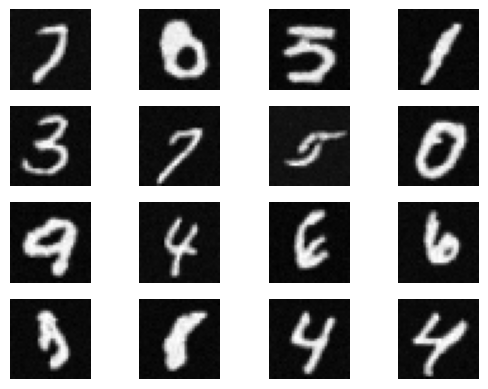

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.34it/s]


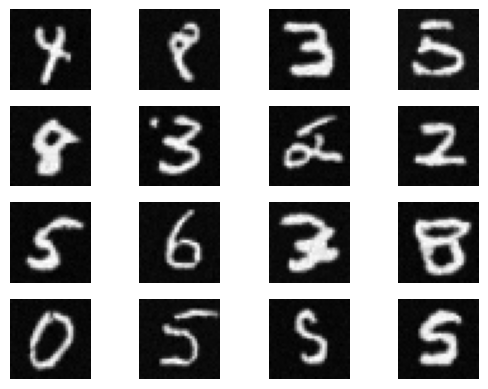

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.30it/s]


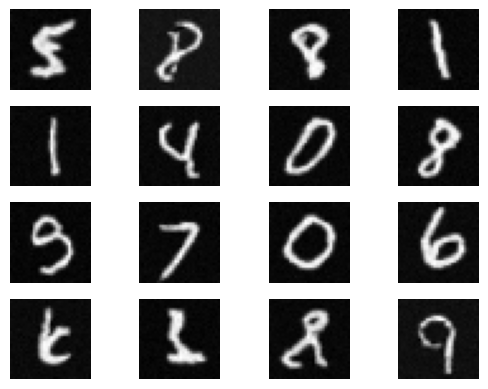

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.35it/s]


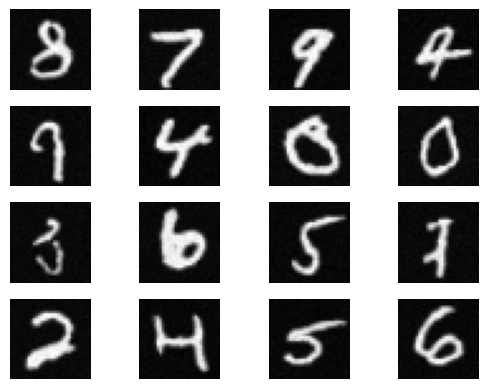

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.35it/s]


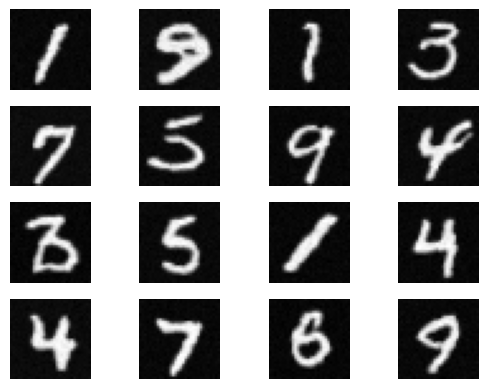

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.35it/s]


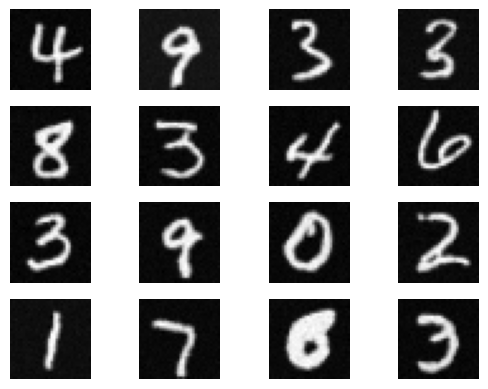

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.34it/s]


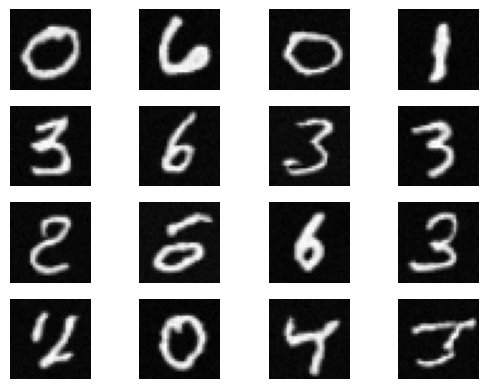

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.34it/s]


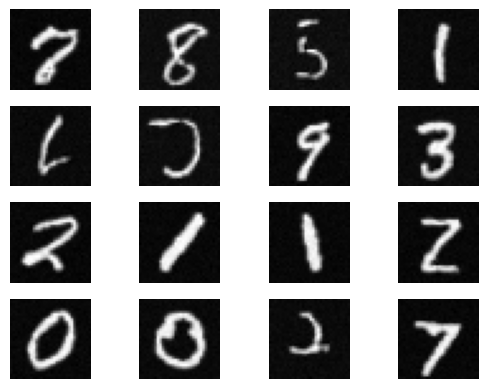

Sampling: 100%|██████████| 1000/1000 [00:54<00:00, 18.34it/s]


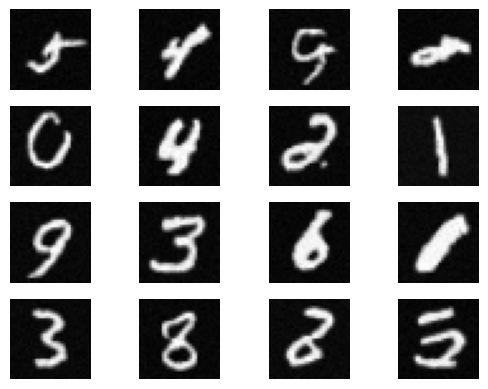

Epoch 20:  96%|█████████▌| 899/938 [06:27<00:16,  2.33it/s, loss=0.007181109]

In [ ]:
class MNISTDataset(torchvision.datasets.MNIST):
    def __init__(self, image_size):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(image_size),
            torchvision.transforms.ToTensor(),
        ])

        super().__init__("data", train=True, download=True, transform=transform)

    def __getitem__(self, item):
        return super().__getitem__(item)[0]

def plot_samples(tensor):
    # Assuming you have a tensor of size torch.Size([16, 1, 32, 32])
    # Convert the tensor to a numpy array
    images = tensor.numpy()

    # Reshape the images to be of size (16, 32, 32)
    images = np.reshape(images, (16, 32, 32))

    # Create a figure with a grid of subplots
    fig, axes = plt.subplots(nrows=4, ncols=4)

    # Iterate over the images and plot them on the subplots
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')

    # Show the plot
    plt.show()


class Configs:
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # U-Net model for epsilon_theta(x_t, t)
    eps_model: UNet
    # DDPM algorithm
    diffusion: DenoiseDiffusion

    # Number of channels in the image. 3 for RGB.
    image_channels: int = 1
    # Image size
    image_size: int = 32
    # Number of channels in the initial feature map
    n_channels: int = 64
    # The list of channel numbers at each resolution.
    # The number of channels is `channel_multipliers[i] * n_channels`
    channel_multipliers: List[int] = [1, 2, 2, 4]
    # The list of booleans that indicate whether to use attention at each resolution
    is_attention: List[int] = [False, False, False, True]

    # Number of time steps T
    n_steps: int = 1_000
    # Batch size
    batch_size: int = 64
    # Number of samples to generate
    n_samples: int = 16
    # Learning rate
    learning_rate: float = 2e-5

    # Number of training epochs
    epochs: int = 20

    # Dataset
    dataset: torch.utils.data.Dataset = MNISTDataset(image_size)
    # Dataloader
    data_loader: torch.utils.data.DataLoader

    # Adam optimizer
    optimizer: torch.optim.Adam

    def init(self):
        # Create epsilon_theta(x_t, t) model
        self.eps_model = UNet(
            image_channels=self.image_channels,
            n_channels=self.n_channels,
            ch_mults=self.channel_multipliers,
            is_attn=self.is_attention,
        ).to(self.device)

        # Create DDPM class
        self.diffusion = DenoiseDiffusion(
            eps_model=self.eps_model,
            n_steps=self.n_steps,
            device=self.device,
        )

        # Create dataloader
        self.data_loader = torch.utils.data.DataLoader(self.dataset, self.batch_size, shuffle=True, pin_memory=True)
        # Create optimizer
        self.optimizer = torch.optim.Adam(self.eps_model.parameters(), lr=self.learning_rate)

    def sample(self):
        with torch.no_grad():
            # [1]
            x = torch.randn(self.n_samples, self.image_channels, self.image_size, self.image_size, device=self.device)
            # print(x)
            # Remove noise for T steps
            progress_bar = tqdm(range(self.n_steps))
            for t_ in progress_bar:
                progress_bar.set_description(f"Sampling")
                # t
                t = self.n_steps - t_ - 1
                # [2]
                x = self.diffusion.p_sample(x, x.new_full((self.n_samples,), t, dtype=torch.long))
            # print(x)
            # print("-"*50)

            # Log samples
            plot_samples(x.detach().cpu())

    def train(self, epoch):
        # Iterate through the dataset
        progress_bar = tqdm(self.data_loader)
        for data in progress_bar:
            # Increment global step
            progress_bar.set_description(f"Epoch {epoch + 1}")
            # Move data to device
            data = data.to(self.device)

            # Make the gradients zero
            self.optimizer.zero_grad()

            # Calculate loss
            loss = self.diffusion.loss(data)
            # Compute gradients
            loss.backward()

            # Take an optimization step
            self.optimizer.step()

            # Track the loss
            progress_bar.set_postfix(loss=loss.detach().cpu().numpy())

    def run(self):
        for epoch in range(self.epochs):
            # Train the model
            self.train(epoch)
            # Sample some images
            self.sample()


# Create configurations
configs = Configs()

# Initialize
configs.init()

# Start and run the training loop
configs.run()